#A Bayesian Model to check Credit worthiness for German Dataset**

## A Bayesian Network to model to learn the association between the traits and attributes of different borrowers in history  and their repayment status Whether it resulted in good risk or a bad risk

## Author: [Jyoti Yadav](jyoti.yadav@studio.unibo.it)

### Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna



# 1. Installing pgmpy

In [1]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 4.2 MB/s 


# Necessary Imports

In [2]:
import pandas as pd 
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator,HillClimbSearch, MaximumLikelihoodEstimator, BicScore
from pgmpy.factors.discrete import State
from pgmpy.factors.discrete import TabularCPD
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
%matplotlib inline
import time

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Reading csv file

In [3]:
df=pd.read_csv('/content/german_credit.csv')

In [4]:
df.shape

(1000, 10)

Converting the whole dataframe into type of string

In [5]:
df.astype(str)

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,nan,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,31,female,1,own,little,1736,12,furniture/equipment,good
996,2,40,male,3,own,little,3857,30,car,good
997,2,38,male,2,own,little,804,12,radio/TV,good
998,2,23,male,2,free,little,1845,45,radio/TV,bad


In [6]:
df.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,NaN,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad


# Data Cleaning

Savings account have lot of nan values

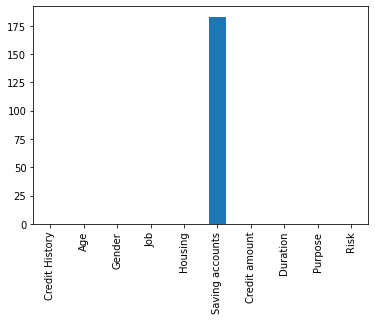

In [7]:
df.isnull().sum().plot(kind='bar')

Get the numer of values in the column and also 
Get the number of unique values in the savings acount

In [8]:
df['Saving accounts'].value_counts()
df['Saving accounts'].unique()

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

NAN is a valid field here impying no saving account hence we can replace it with 'no account'



In [9]:
df.loc[df['Saving accounts'].isnull(),'Saving accounts']='no accounts'

Verifying the number of unique values in the dataframe

In [10]:
df['Saving accounts'].value_counts()
df['Saving accounts'].unique()

little         603
no accounts    183
moderate       103
quite rich      63
rich            48
Name: Saving accounts, dtype: int64

array(['no accounts', 'little', 'quite rich', 'rich', 'moderate'],
      dtype=object)

Checking for the null values in the dataframe

In [11]:
df.isnull().sum()

Credit History     0
Age                0
Gender             0
Job                0
Housing            0
Saving accounts    0
Credit amount      0
Duration           0
Purpose            0
Risk               0
dtype: int64

In [12]:
df.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,67,male,2,own,no accounts,1169,6,radio/TV,good
1,2,22,female,2,own,little,5951,48,radio/TV,bad
2,4,49,male,1,own,little,2096,12,education,good
3,2,45,male,2,free,little,7882,42,furniture/equipment,good
4,3,53,male,2,free,little,4870,24,car,bad


We have the target here Risk 

In [13]:
target='Risk'

Let's make a list of numerical features which needs to be binned

In [14]:
col_list=[]
for col in df.columns:
  print(col,":",len(df[col].unique()))
  if(len(df[col].unique())>32):
    col_list.append(col)

Credit History : 5
Age : 53
Gender : 2
Job : 4
Housing : 3
Saving accounts : 5
Credit amount : 921
Duration : 33
Purpose : 8
Risk : 2


In [15]:
col_list

['Age', 'Credit amount', 'Duration']

Lets make the final dataframe a little cleaner to understand the range of values it can take based on its min and max value

Age has min and max as 19 and 75 respectively

In [16]:
min(df['Age'].unique()), max(df['Age'].unique())
bin_age = ['19 to 28', '28 to 38', '38 to 75']

(19, 75)

Credit amount has min and max as 250 and 18424 respectively

In [17]:
min(df['Credit amount'].unique()), max(df['Credit amount'].unique())
bin_credit_amount = ['250 to 1554', '1554 to 3368', '3368 to 18424']

(250, 18424)

Duration has min and max as 4 and 72 respectively

In [18]:
min(df.Duration.unique()), max(df.Duration.unique())
bin_duration = ['4 to 12', '12 to 24', '24 to 72']

(4, 72)

DataFrame features by its bins

In [19]:
df['Age']=pd.cut(df['Age'],3,labels=bin_age)
df['Credit amount']=pd.cut(df['Credit amount'],3,labels=bin_credit_amount)
df['Duration']=pd.cut(df['Duration'],3,labels=bin_duration)

In [20]:
df

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,38 to 75,male,2,own,no accounts,250 to 1554,4 to 12,radio/TV,good
1,2,19 to 28,female,2,own,little,250 to 1554,12 to 24,radio/TV,bad
2,4,28 to 38,male,1,own,little,250 to 1554,4 to 12,education,good
3,2,28 to 38,male,2,free,little,1554 to 3368,12 to 24,furniture/equipment,good
4,3,28 to 38,male,2,free,little,250 to 1554,4 to 12,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,2,19 to 28,female,1,own,little,250 to 1554,4 to 12,furniture/equipment,good
996,2,28 to 38,male,3,own,little,250 to 1554,12 to 24,car,good
997,2,28 to 38,male,2,own,little,250 to 1554,4 to 12,radio/TV,good
998,2,19 to 28,male,2,free,little,250 to 1554,12 to 24,radio/TV,bad


#Train and Test

Splitting the data into train and test 

In [21]:
np.random.seed(50)
sample = np.random.choice(df.index, size=int(len(df) * 0.8), replace=False)
#complete data
print(df.shape)

#Training data
train_data = df.iloc[sample]
print(train_data.shape)

#Testing data
test_data = df.drop(sample)
print(test_data.shape)

#Testing target
test_y = test_data['Risk']
print(test_y.shape)

#Testing features
test_data.drop(columns=['Risk'], inplace=True)
print(test_data.shape)

(1000, 10)
(800, 10)
(200, 10)
(200,)
(200, 9)


In [22]:
df.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,38 to 75,male,2,own,no accounts,250 to 1554,4 to 12,radio/TV,good
1,2,19 to 28,female,2,own,little,250 to 1554,12 to 24,radio/TV,bad
2,4,28 to 38,male,1,own,little,250 to 1554,4 to 12,education,good
3,2,28 to 38,male,2,free,little,1554 to 3368,12 to 24,furniture/equipment,good
4,3,28 to 38,male,2,free,little,250 to 1554,4 to 12,car,bad


#Model Building

#Model1

From the previous analysis, I defined the following network structure.

Nodes ['Risk', 'Credit History', 'Age', 'Housing', 'Job', 'Credit amount', 'Duration', 'Saving accounts', 'Gender'] 

Edges [('Risk', 'Credit History'), ('Risk', 'Saving accounts'), ('Age', 'Housing'), ('Job', 'Credit amount'), ('Credit amount', 'Housing'), ('Credit amount', 'Duration'), ('Gender', 'Housing')]


<Figure size 1080x720 with 0 Axes>

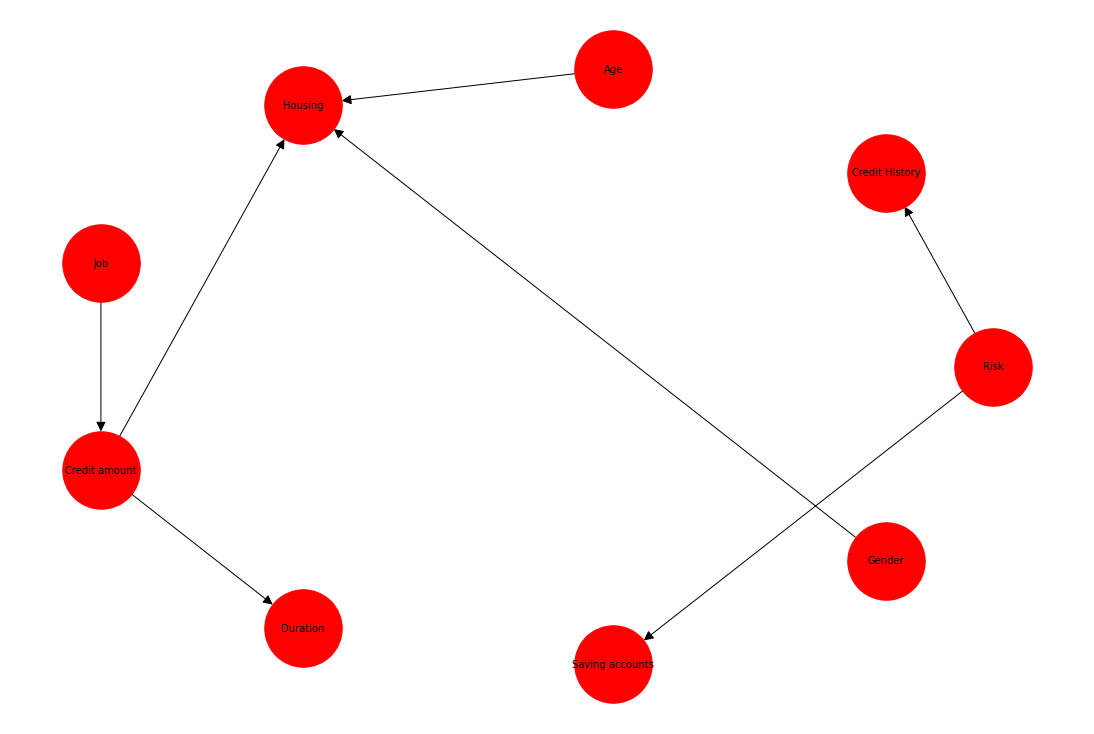

In [23]:
#My custom model

model11=BayesianModel([('Risk','Credit History'),
                     ('Age','Housing'),
                     ('Job','Credit amount'),
                     ('Credit amount','Housing'),
                     ('Credit amount','Duration'),
                     ('Risk','Saving accounts'),
                     ('Gender','Housing')])

print('Nodes',model11.nodes(),'\n')
print('Edges',model11.edges())

plt.figure(figsize=(15,10))
nx.draw_circular(model11, with_labels=True, arrowsize=20, node_size=6000, font_size=10,node_color='red')
plt.show()

Fit the model11

In [24]:
model11.fit(data=df,estimator=BayesianEstimator,prior_type="BDeu",equivalent_sample_size=10,complete_samples_only=False)

#Model2

**Hill climbing algorithm** is a local search algorithm which continuously moves in the direction of increasing elevation/value to find the peak of the mountain or best solution to the problem. It terminates when it reaches a peak value where no neighbor has a higher value.


**HillClimbSearch in pgmpy** - Performs local hill climb search to estimates the DAG structure that has optimal score, according to the scoring method supplied. Starts at model start_dag and proceeds by step-by-step network modifications until a local maximum is reached. Only estimates network structure, no parametrization.

It returns a model Returns model – A DAG at a (local) score maximum.

Here i have used **BicScore** to generate a model

###Model Building and Parameter Learning

  0%|          | 0/1000000 [00:00<?, ?it/s]

<Figure size 1080x720 with 0 Axes>

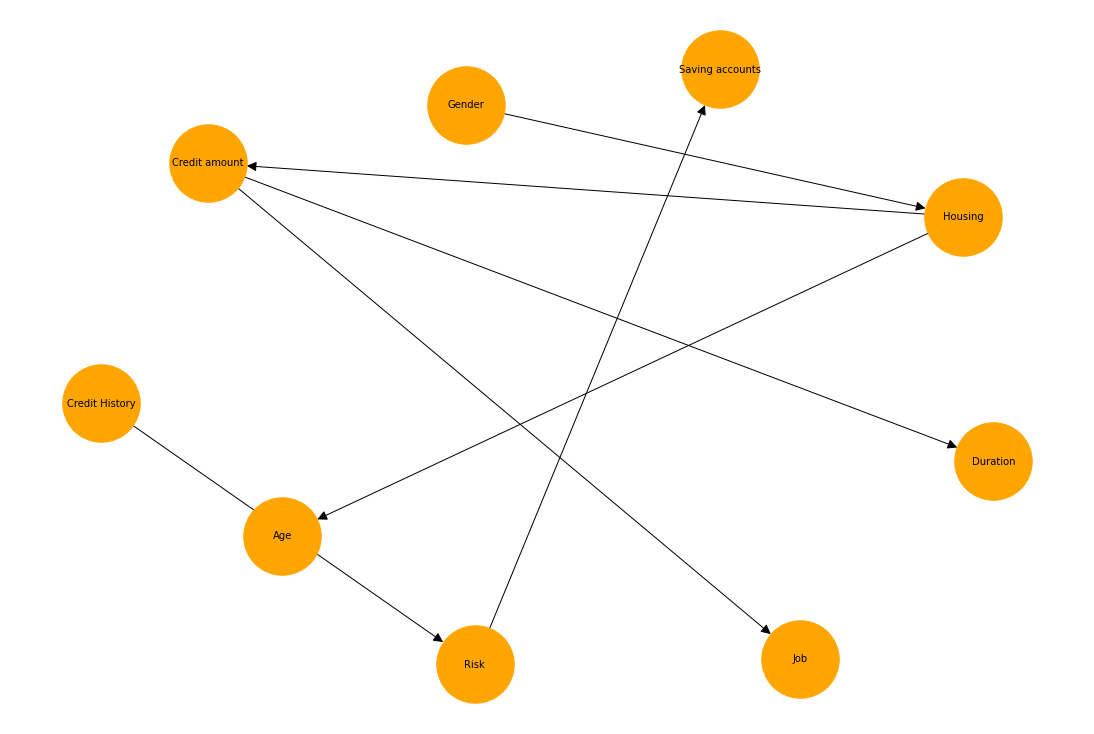

In [25]:
model2 = HillClimbSearch(train_data)
best_model = model2.estimate(scoring_method=BicScore(train_data))
edges = list(best_model.edges())
model22 = BayesianModel(edges)

plt.figure(figsize=(15,10))
nx.draw(model22, pos=nx.spring_layout(model22),with_labels=True, arrowsize=20, node_size=6000, font_size=10,node_color='orange')
plt.show()

Fit the mode22

# Fitting the data to the model using Maximum Likelihood Estimator

In [26]:
model22.fit(train_data, estimator=MaximumLikelihoodEstimator)

In [27]:
df.head()

,Credit History,Age,Gender,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,4,38 to 75,male,2,own,no accounts,250 to 1554,4 to 12,radio/TV,good
1,2,19 to 28,female,2,own,little,250 to 1554,12 to 24,radio/TV,bad
2,4,28 to 38,male,1,own,little,250 to 1554,4 to 12,education,good
3,2,28 to 38,male,2,free,little,1554 to 3368,12 to 24,furniture/equipment,good
4,3,28 to 38,male,2,free,little,250 to 1554,4 to 12,car,bad


#Prediction

##model1

In [45]:
columns = list(model11.nodes)
columns.remove('Risk')

y_pred = model11.predict(test_data[columns])['Risk']
# evaluate predictions
acc = accuracy_score(test_y, y_pred)
print('Accuracy Bayesian Model : %.3f' % acc)

  0%|          | 0/151 [00:00<?, ?it/s]

Accuracy Bayesian Model : 0.775


##model2

In [47]:
columns = list(model22.nodes)
columns.remove('Risk')

y_pred = model22.predict(test_data[columns])['Risk']
# evaluate predictions
acc = accuracy_score(test_y, y_pred)
print('Accuracy HillSearchModel : %.3f' % acc)

  0%|          | 0/151 [00:00<?, ?it/s]

Accuracy HillSearchModel : 0.765


#Conditional Probability Distribution


In [48]:
l1=model11.get_cpds()
for cpd in l1:
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

CPT of Risk:
+------------+---------+
| Risk(bad)  | 0.30198 |
+------------+---------+
| Risk(good) | 0.69802 |
+------------+---------+ 

CPT of Credit History:
+-------------------+---------------------+----------------------+
| Risk              | Risk(bad)           | Risk(good)           |
+-------------------+---------------------+----------------------+
| Credit History(0) | 0.08524590163934426 | 0.02269503546099291  |
+-------------------+---------------------+----------------------+
| Credit History(1) | 0.09508196721311475 | 0.031205673758865248 |
+-------------------+---------------------+----------------------+
| Credit History(2) | 0.5573770491803278  | 0.5134751773049645   |
+-------------------+---------------------+----------------------+
| Credit History(3) | 0.09508196721311475 | 0.08652482269503546  |
+-------------------+---------------------+----------------------+
| Credit History(4) | 0.16721311475409836 | 0.34609929078014184  |
+-------------------+------------

#Independences

In [49]:
for i in model11.nodes():
  print(" Independencies :",i,'\n',model11.local_independencies(i))
  print(" Descendants :",i,'\n',model11.get_children(i))
  print('\n')


 Independencies : Risk 
 (Risk ⟂ Duration, Gender, Housing, Age, Job, Credit amount)
 Descendants : Risk 
 ['Credit History', 'Saving accounts']


 Independencies : Credit History 
 (Credit History ⟂ Duration, Gender, Housing, Saving accounts, Age, Job, Credit amount | Risk)
 Descendants : Credit History 
 []


 Independencies : Age 
 (Age ⟂ Duration, Credit History, Gender, Risk, Saving accounts, Job, Credit amount)
 Descendants : Age 
 ['Housing']


 Independencies : Housing 
 (Housing ⟂ Duration, Credit History, Risk, Saving accounts, Job | Gender, Age, Credit amount)
 Descendants : Housing 
 []


 Independencies : Job 
 (Job ⟂ Credit History, Gender, Risk, Saving accounts, Age)
 Descendants : Job 
 ['Credit amount']


 Independencies : Credit amount 
 (Credit amount ⟂ Credit History, Gender, Risk, Saving accounts, Age | Job)
 Descendants : Credit amount 
 ['Housing', 'Duration']


 Independencies : Duration 
 (Duration ⟂ Credit History, Housing, Gender, Risk, Saving accounts, Age, 

#Markov Blanket

In [50]:
for i in model11.nodes():
  print(" markov Blanket :",i,'\n', model11.get_markov_blanket(i))
  print('\n')


 markov Blanket : Risk 
 ['Saving accounts', 'Credit History']


 markov Blanket : Credit History 
 ['Risk']


 markov Blanket : Age 
 ['Gender', 'Housing', 'Credit amount']


 markov Blanket : Housing 
 ['Gender', 'Age', 'Credit amount']


 markov Blanket : Job 
 ['Credit amount']


 markov Blanket : Credit amount 
 ['Duration', 'Housing', 'Age', 'Job', 'Gender']


 markov Blanket : Duration 
 ['Credit amount']


 markov Blanket : Saving accounts 
 ['Risk']


 markov Blanket : Gender 
 ['Age', 'Housing', 'Credit amount']




#we can also find the parents and children of the target

In [51]:
model11.get_children(target)

['Credit History', 'Saving accounts']

In [52]:
model11.get_parents(target)

[]

#Active Trail 

#1. Is there any active trail between the Age and Risk?

In [53]:
model11.is_dconnected("Age","Risk")

False

#2. Is there any active trail between the Risk and Gender?

In [54]:
model11.is_dconnected("Gender","Risk")

False

#3. Is there any active trail between the Risk and Credit History?

In [55]:
model11.is_dconnected("Credit History","Risk")

True

#4. Is there any active trail between the Risk and Savings accounts?

In [56]:
model11.is_dconnected("Saving accounts","Risk")

True

# Inferences

In pgmpy it is possible to perform inference on a Bayesian network through the Variable Elimination method

In [57]:
infer=VariableElimination(model11)

#**Inference1**: Given the knowledge of credit history of the borrower, what can we infer about the risk associated with the profile.Improved credit history signals better credit worthiness

In [58]:
for i in [0,1,2,3,4]:
    print("Credit History:", i)
    print(infer.query(variables=[target], evidence = {'Credit History': i}))

Credit History: 0


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.6190 |
+------------+-------------+
| Risk(good) |      0.3810 |
+------------+-------------+
Credit History: 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.5686 |
+------------+-------------+
| Risk(good) |      0.4314 |
+------------+-------------+
Credit History: 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3195 |
+------------+-------------+
| Risk(good) |      0.6805 |
+------------+-------------+
Credit History: 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3222 |
+------------+-------------+
| Risk(good) |      0.6778 |
+------------+-------------+
Credit History: 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1729 |
+------------+-------------+
| Risk(good) |      0.8271 |
+------------+-------------+


Conclusion : With the Credit History 4.We can see Risk(good) is 82%.The person with the credit History 4 has a good profile

#**Inference2** - We have observed when the Saving Accounts of a person is rich and quite rich bad risk reduces and the probability of good risks are 86% and 81% in both the respective cases

In [41]:
feat = 'Saving accounts'
list_range = ['little', 'moderate', 'rich', 'quite rich']

for i in list_range:
    print(i)
    print(infer.query(variables=[target], evidence = {feat: i}))

little


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3603 |
+------------+-------------+
| Risk(good) |      0.6397 |
+------------+-------------+
moderate


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3333 |
+------------+-------------+
| Risk(good) |      0.6667 |
+------------+-------------+
rich


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1400 |
+------------+-------------+
| Risk(good) |      0.8600 |
+------------+-------------+
quite rich


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.1846 |
+------------+-------------+
| Risk(good) |      0.8154 |
+------------+-------------+


#**Inference 3**- Duration Loans with shorter duration are mostly repaid without default, the bad risk i.e. credit worthiness deteriorates as duration increases. Note that it justifies the intuition that the longer the period, it induces more volatility into the system, where volatility might be construed as more risk

In [42]:
### Effect of Duration on 'Credit Risk'
list_range = bin_duration
for i in list_range:
    print(i)
    print(infer.query(variables=[target], evidence = {'Duration': i}))

4 to 12


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3020 |
+------------+-------------+
| Risk(good) |      0.6980 |
+------------+-------------+
12 to 24


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3020 |
+------------+-------------+
| Risk(good) |      0.6980 |
+------------+-------------+
24 to 72


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3020 |
+------------+-------------+
| Risk(good) |      0.6980 |
+------------+-------------+


#**Inference 4**- Credit amount Bad risk is maximum for high amount of credits borrowed

In [43]:
list_range = bin_credit_amount
for i in list_range:
    print(i)
    print(infer.query(variables=[target], evidence = {'Credit amount': i}))

250 to 1554


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3020 |
+------------+-------------+
| Risk(good) |      0.6980 |
+------------+-------------+
1554 to 3368


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3020 |
+------------+-------------+
| Risk(good) |      0.6980 |
+------------+-------------+
3368 to 18424


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------------+-------------+
| Risk       |   phi(Risk) |
+============+=============+
| Risk(bad)  |      0.3020 |
+------------+-------------+
| Risk(good) |      0.6980 |
+------------+-------------+
